# Introduction to LSTM

What sets language models apart from conventional neural networks is their dependency on context. Conventional feed-forward networks assume inputs to be independent of one another. For NLP, we need a mechanism to be able to use sequential information from previous inputs to determine the current output. Recurrent Neural Networks (RNNs) tackle this problem by having loops, allowing information to persist through the network.

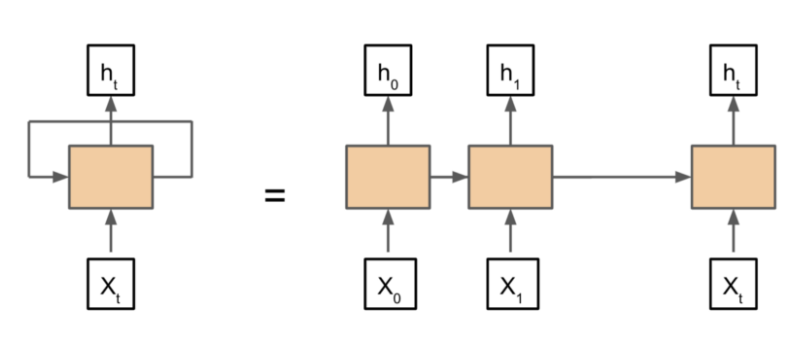

Long Short Term Memory networks (LSTM) are a special kind of RNN, which are capable of learning long-term dependencies. They do so by maintaining an internal memory state called the “cell state” and have regulators called “gates” to control the flow of information inside each LSTM unit.
for more information about those models you can visit this link:
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

So in this notebook we'll perform a regression using LSTM model (using PyTorch) applied on the excerpt texts of our dataset and explore the results

# Necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import spacy
import re
from collections import Counter
import string
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Dataset

In [ ]:
train_file = "../input/commonlitreadabilityprize/train.csv"

In [ ]:
# Loading the data
data = pd.read_csv(train_file)
print(data.shape)
data.head()

# Preprocessing

In [ ]:
# Tokenization
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
# Count number of occurences of each word
counts = Counter()
for text in list(data['excerpt']):
    counts.update(tokenize(text))

In [ ]:
# Deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

In [ ]:
# Creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
def encode_sentence(text, vocab2index, N=200):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
data['encoded'] = data['excerpt'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
data.head()

# PyTorch Dataset

In [ ]:
class CommonLitReadabiltyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
X = list(data['encoded'])
y = list(data['target'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

train_ds = CommonLitReadabiltyDataset(X_train, y_train)
valid_ds = CommonLitReadabiltyDataset(X_valid, y_valid)

# PyTorch training loop

In [ ]:
def train_model_regr(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.float()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.mse_loss(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics_regr(model, val_dl)
        if i % 5 == 1:
            print("train mse %.3f val rmse %.3f" % (sum_loss/total, val_loss))

def validation_metrics_regr (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.float()
        y_hat = model(x, l)
        loss = np.sqrt(F.mse_loss(y_hat, y.unsqueeze(-1)).item())
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

In [ ]:
batch_size = 64
vocab_size = len(words)
embedding_dim = 300
hidden_dim = 200
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

# LSTM regression model

In [ ]:
class LSTM_regr(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
model =  LSTM_regr(vocab_size, embedding_dim, hidden_dim)

In [ ]:
train_model_regr(model, epochs=30, lr=0.005)

# Load Glove vectors

In [ ]:
glove_embedding_vectors_text_file = "../input/embeddings-glove-crawl-torch-cached/crawl-300d-2M.vec"
glove_embedding_vectors_pt_file = "../input/embeddings-glove-crawl-torch-cached/crawl-300d-2M.vec.pt"

In [ ]:
# We can load the vectors using our custom functions
def load_glove_vectors(glove_file= glove_embedding_vectors_text_file):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

def get_emb_matrix(pretrained, word_counts, emb_size = 300):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [ ]:
# Or we can do it directly 
itos, stoi, pretrained_weights, embedding_dim = torch.load(glove_embedding_vectors_pt_file)
vocab_size = pretrained_weights.size(0)
pretrained_weights = pretrained_weights.numpy()

# LSTM Model with Golve vectors

In [ ]:
class LSTM_reg_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## Freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
model_glove = LSTM_reg_glove_vecs(vocab_size, embedding_dim, hidden_dim, pretrained_weights)

In [ ]:
train_model_regr(model_glove, epochs=30, lr=0.005)

You can see that using the glove embedding vectors we achieve a better rmse value than using random embedding vectors. You can tweak some parameters in order to get much better performance.

# LSTM + attention model

In [ ]:
class PositionAwareAttention(nn.Module):
    
    def __init__(self, input_size, attn_size):
        super().__init__()
        self.input_size  = input_size
        self.wx = nn.Conv1d(input_size, attn_size, 1, bias=True)  # from input to attention matrix
        self.wh = nn.Conv1d(input_size, attn_size, 1, bias=False) # from hidden to attention matrix
        self.wt = nn.Conv1d(attn_size, 1, 1, bias=True)           # from attention matrix to score
        
    def forward(self, x, h):
        x = x.permute(1,2,0) # features last
        wx = self.wx(x)
        wh = self.wh(h.permute(1,0,2).contiguous().view(-1,self.input_size,1))
        score = self.wt(torch.tanh(wx + wh))
        score = F.softmax(score, dim=2)
        out = torch.bmm(score, x.permute(0,2,1)).squeeze()
        
        return out

In [ ]:
class RecNN(nn.Module):
    def __init__(self, embs_dim, hidden_size, glove_weights, layers=1, atten_features = 24, 
                 dropout=0., bidirectional=False):
        super().__init__()

        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_layers = layers
        self.emb_dim = embs_dim
        self.emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.emb.weight.data.copy_(torch.from_numpy(glove_weights)) # load pretrained vectors
        self.emb.weight.requires_grad = False # make embedding non trainable
        
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_size,
                            num_layers=layers, bidirectional=bidirectional, dropout=dropout)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_size,
                            num_layers=layers, bidirectional=bidirectional, dropout=dropout)
        self.pregru = nn.Conv1d(self.emb_dim, self.emb_dim, 1, bias=True)
        self.atten = PositionAwareAttention(hidden_size*(bidirectional+1), atten_features)
        
        self.out = nn.Linear(2* hidden_size*(bidirectional+1), 32)
        self.last = nn.Linear(32, 1)
    def forward(self, x, l):
        
        embs = self.emb(x)
        
        lstm, (h1, c) = self.lstm(embs)
        gru = F.relu(self.pregru(embs.permute(1,2,0)), inplace=True).permute(2,0,1)
        
        gru, h2 = self.gru(gru, h1)
        lstm = lstm + gru
        
        x_max, _ = lstm.max(dim=0, keepdim=False) 
        x_atten = self.atten(lstm, h1+h2)
        out = self.out(torch.cat([x_max, x_atten],dim = 1))
        out = self.last(F.relu(out)).squeeze()
        return out

In [ ]:
model_LSTM_attention = RecNN(embedding_dim, hidden_dim, pretrained_weights, dropout=0.4)

In [ ]:
train_model_regr(model_LSTM_attention, epochs=30, lr=0.005)

# Inference & Test

In [ ]:
checkpoint_path = "./LSTM_regr_model_with_glove.pth"
torch.save(model_glove, checkpoint_path)

In [ ]:
# Load in the best model
model = torch.load(checkpoint_path)
model.eval()

# Read the test excerpts
test_data = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
print(test_data.head())

# Apply the same encoding as the train texts
test_data['encoded'] = test_data['excerpt'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
idx, excerpts_test = test_data['id'], test_data['encoded']

X_test = [excerpts_test[i][0] for i in range(len(test_data))]
l_test = [excerpts_test[i][1] for i in range(len(test_data))]
X_test = torch.LongTensor(X_test)

# Create Submission File

In [ ]:
# Apply the trained model
y_hat = model(X_test, l_test)
test_target = y_hat.reshape(-1).tolist()

my_submission = pd.DataFrame({'id': idx, 'target': test_target})
my_submission.to_csv('submission.csv', index=False)
my_submission.head()

If you find the notebook helpful and interesting please upvote it ! 